### Imports

## Set up Colab

In [25]:
!/opt/bin/nvidia-smi
!pip install tensorflow-gpu==1.15.0

zsh:1: no such file or directory: /opt/bin/nvidia-smi
distutils: /Library/Frameworks/Python.framework/Versions/3.7/include/python3.7m/UNKNOWN
sysconfig: /Library/Frameworks/Python.framework/Versions/3.7/include/python3.7m
user = False
home = None
root = None
prefix = None
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==1.15.0 (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu==1.15.0
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3 -m pip install --upgrade pip' command.


## Mount your drive

In [26]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

## Change directory to the script

In [27]:
import os
path = "/path/to/RNN_workingmemoryaccuracy"#example:"/content/drive/My Drive/RNN_workingmemoryaccuracy"
os.chdir(path)
!pwd

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/RNN_workingmemoryaccuracy'

In [3]:
import numpy as np
from numpy import *
from matplotlib import pyplot as plt
import matplotlib as mpl
# sys.path.append('.')
from utils import tools
from scipy.stats.stats import pearsonr
from utils.tools import mkdir_p,auto_model_select,smooth
import statistics
from utils.functions import gen_task_info, split_trials, select_H_by_trialidx, select_neurons_excitatory
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### GPU set up

### Load model directory

In [5]:
model_dir = 'data/6tasks_8loc_256neuron_odr3000_seed0'

### Load model saved infomation

In [6]:
hp = tools.load_hp(model_dir)
log = tools.load_log(model_dir)

### Model parameters

In [7]:
stage = 'mature'
rule = 'odr3000'
epoch = 'delay1' # delay period

In [8]:
# prepare task info
task_info = gen_task_info(hp,model_dir,[rule])

Epoch information:
	odr3000:
		fix1: (None, 50)
		stim1: (50, 75)
		delay1: (75, 225)
		go1: (225, None)


In [9]:
# select one model and compute model performance
model_select_odr3000 = {'mature':748800,'mid':710400,'early':604160}
models_select = model_select_odr3000
model_idx = log['trials'].index(models_select[stage])
model_perf = log['perf_' + rule][model_idx]

In [10]:
# find correct trials and split them into clockwise and counterclockwise trials
all_H, correct_idx, correct_cw_idx, correct_ccw_idx, all_stage_keys, all_in_loc_info, dev_theta = split_trials(hp,log, model_dir, rule, [models_select[stage]], task_info, trial=None, task_mode='test')

In [11]:
# correct trials firing rate matrix (Time, Batch, Unit) and location information
correct_H = select_H_by_trialidx(all_H,correct_idx)
correct_loc_info = np.array(all_in_loc_info)[correct_idx]

In [12]:
# Neurons selection
significant_neuron_all = np.arange(hp['n_rnn'])
print('# all_significant_neuron = ', len(significant_neuron_all))
significant_neuron_delay = select_neurons_excitatory(hp, rule, task_info, epoch, correct_H, correct_loc_info)
print('# delay_significant_neuron = ', len(significant_neuron_delay))

# all_significant_neuron =  256
# delay_significant_neuron =  114


### Averaged R of 8 locations

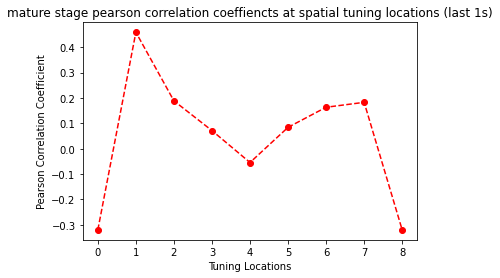

In [13]:
from Averaged_R_tuning_locs import plot_R_last
time_50 = 50 
plot_R_last(correct_idx, correct_cw_idx, correct_ccw_idx, epoch, rule, correct_H, correct_loc_info,
                            task_info, significant_neuron_delay, dev_theta,model_perf,stage,'delay_neurons',time_50)

### Fano factor

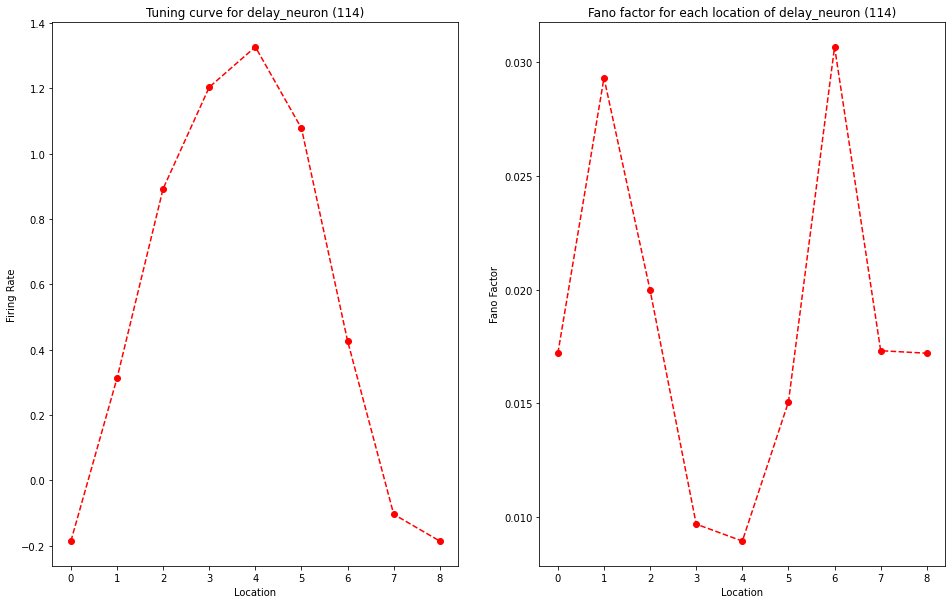

In [28]:
from single_neuron_fano_factor import plot_fano_tuning_average_last
time_50 = 50
plot_fano_tuning_average_last(correct_H, correct_loc_info, significant_neuron_delay, rule, epoch, task_info,
                                      model_perf, stage, 'delay_neuron', time_50)


### Pearson correlation coefficients mean of saccade deviation vs theta deviation

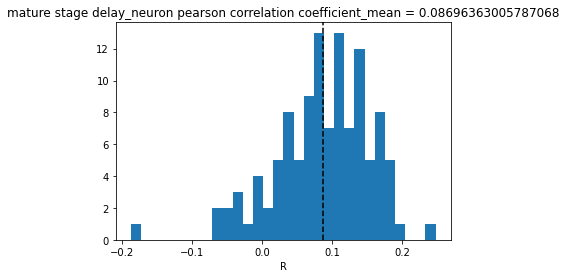

In [29]:
from R_distribution_dev_saccade_dev_fr import R_distribute_last
time_50 = 50
R_distribute_last(correct_idx,correct_cw_idx, correct_ccw_idx, epoch, rule, correct_H, correct_loc_info,
                    task_info, significant_neuron_delay,dev_theta,model_perf,'delay_neuron',time_50,stage)

### Endpoint analysis of correct and error trials 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


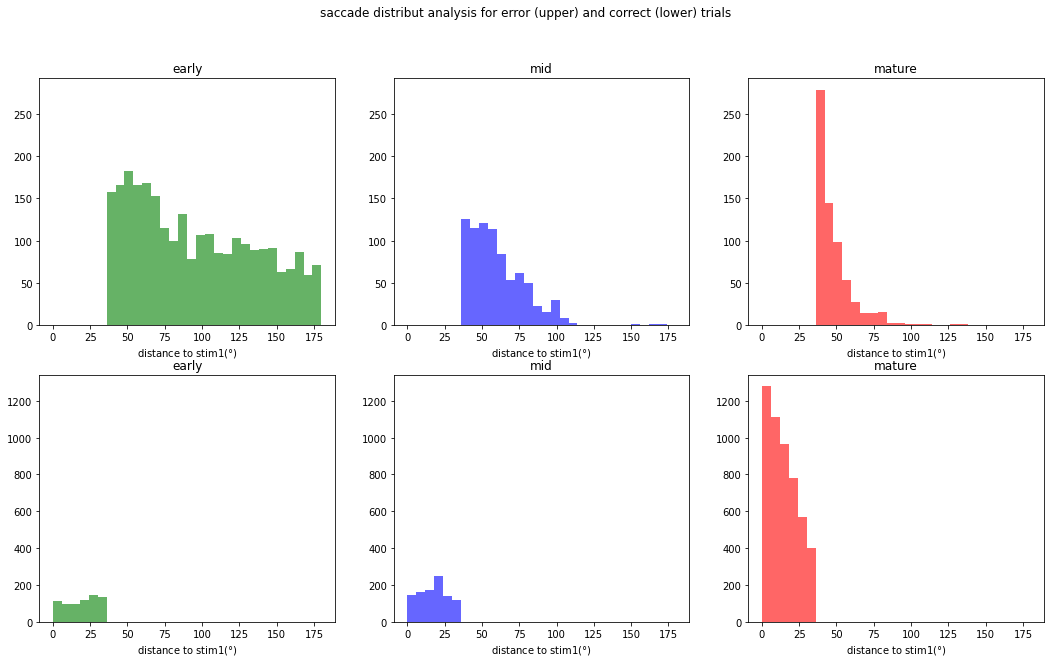

In [30]:
from endpoint_analysis import saccade_distribut_analysis, combined_trial_range
from analysis.PSTH_print_basic_info import print_basic_info

trial_range = print_basic_info(hp, log, model_dir, smooth_growth=True, smooth_window=5, auto_range_select=True)
saccade_distribut_analysis(hp, log, rule, model_dir, trial_list=combined_trial_range(trial_range, rule), )

### Single neuron raster plot

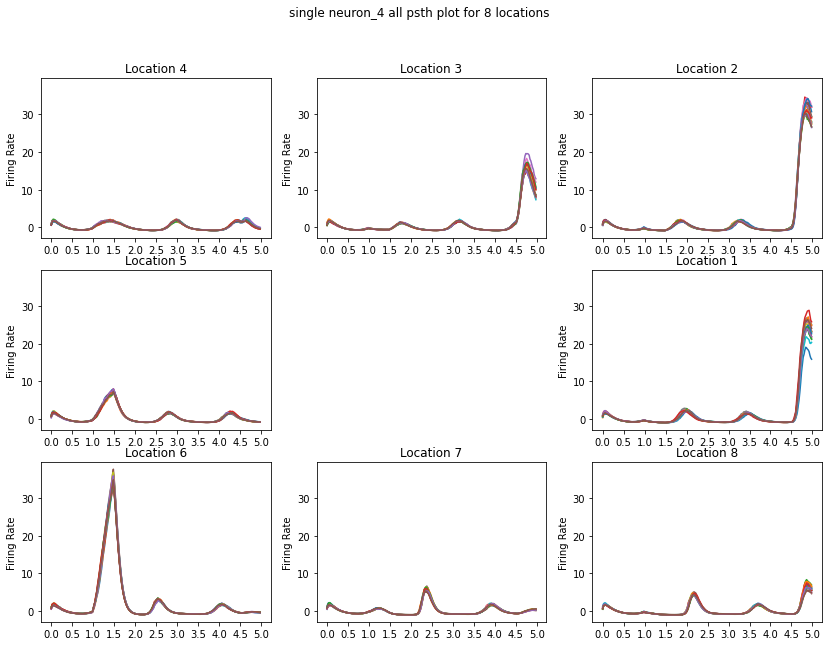

In [31]:
from single_neuron_PSTH import gen_single_neuron_PSTH_
gen_single_neuron_PSTH_(hp, rule, correct_H, correct_loc_info, stage, model_perf,task_info,model_dir)

### Plot PSTH of ODR and ODRD

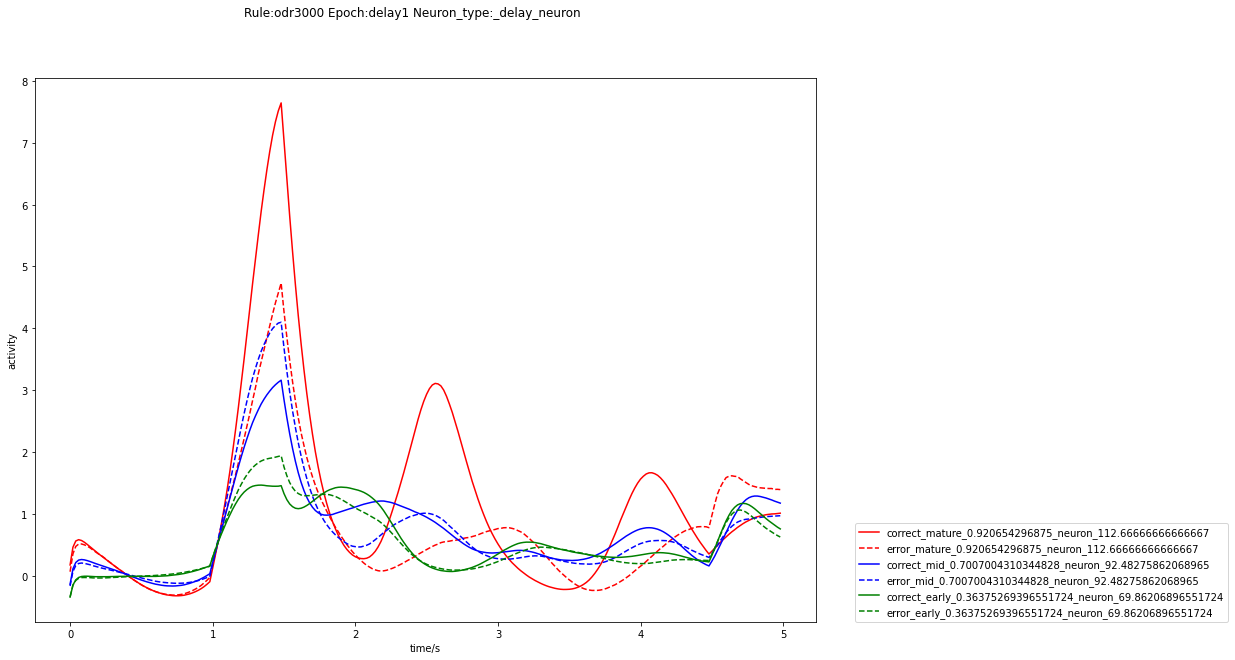

In [14]:
from plot_psth import plot_multiple_model_psth
model_select = auto_model_select(hp, log, smooth_window=9, perf_margin=0.05, max_model_num_limit=30)
# ODR task with normalized firing rate for delay neurons
plot_multiple_model_psth(hp, log, model_dir, rule, epoch, model_select[rule], task_info,'delay_neuron', plot_oppo_dir=False,norm=True, )

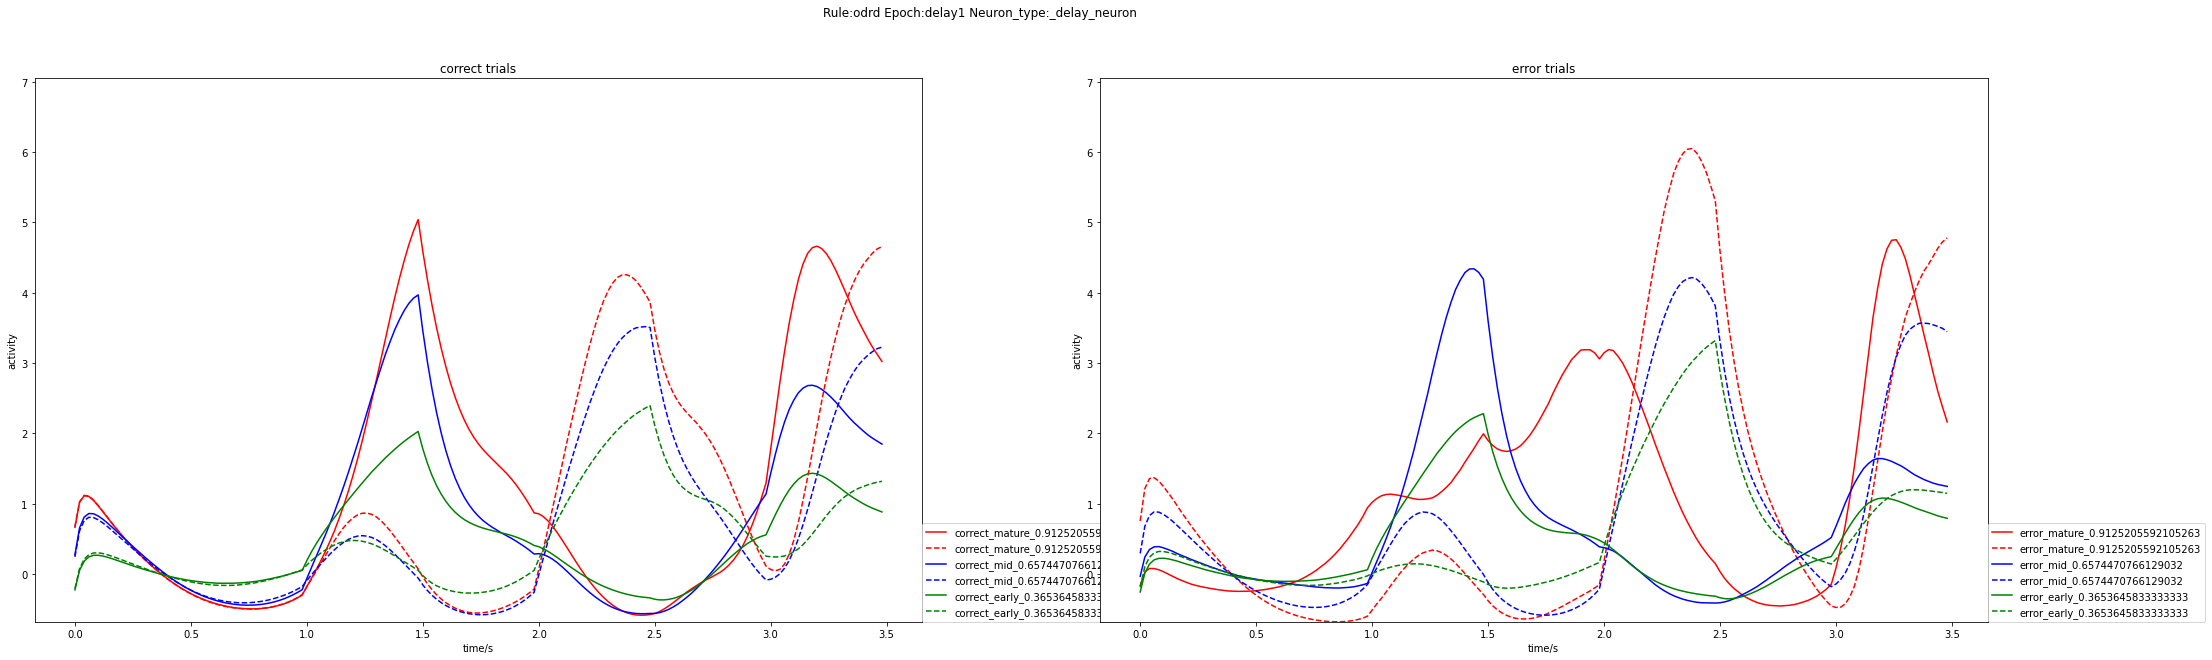

In [17]:
# ODRD task with normalized firing rate for delay neurons
plot_multiple_model_psth(hp, log, model_dir, 'odrd', epoch, model_select['odrd'], task_info, 'delay_neuron', plot_oppo_dir=True,
                         norm=True, )

## Heatmap for 360 locations and 256 units

### model parameters

In [18]:
model_dir_h = 'data/6tasks_360loc_256neuron'
hp_h = tools.load_hp(model_dir_h)
log_h = tools.load_log(model_dir_h)
# model parameters
stage_h = 'mid'
rule_h = 'odr'
norm_h = True

### prepare task info

In [19]:
task_info_h = gen_task_info(hp_h,model_dir_h,[rule_h])

Epoch information:
	odr:
		fix1: (None, 50)
		stim1: (50, 75)
		delay1: (75, 150)
		go1: (150, None)


### select one model

In [20]:
models_select_h = {'mature': 153600, 'mid': 70400, 'early':49920 }
model_idx = log['trials'].index(models_select_h[stage_h])
model_perf = log['perf_'+rule][model_idx]

In [24]:
from neuron_heatmap import gen_multiple_trials_heatmap,find_best_epoch_location

all_H, correct_idx, correct_cw_idx, correct_ccw_idx, all_stage_keys, all_in_loc_info, dev_theta = split_trials(hp_h,log_h, model_dir_h, rule_h, [models_select_h[stage_h]], task_info_h, trial=None, task_mode='test')
# select all neurons
significant_neuron_all = np.arange(hp['n_rnn'])
# print('# all_significant_neuron = ', len(significant_neuron_all))
significant_neuron = significant_neuron_all
best_cue_neuron_info = find_best_epoch_location(rule_h,'stim1',task_info_h,correct_H,correct_loc_info,significant_neuron_all,norm=norm_h)
# plot heatmap with neurons sorted by best cue location
loc_num = 90
gen_multiple_trials_heatmap(rule_h, 'stim1', task_info_h, all_H, correct_cw_idx,correct_ccw_idx, stage_h, best_cue_neuron_info, model_dir_h, loc_num,model_perf,norm=norm_h)


[(0, 2, 0.24165082), (1, 6, 54.40603), (2, 5, 1.4315248), (3, 0, 1.5931509), (4, 5, 35.03243), (5, 3, 0.36747563), (6, 4, 0.3487469), (7, 1, 0.14237225), (8, 5, 14.51772), (9, 4, 0.58563066), (10, 7, 1.1418436), (11, 6, 0.8640679), (12, 4, 0.24691677), (13, 5, 1.5543833), (14, 0, 1.0614288), (15, 1, -0.48852372), (16, 3, 1.0256276), (17, 5, 0.94743097), (18, 7, 1.4171238), (19, 2, 2.8636608), (20, 0, 2.9296238), (21, 7, -0.2668066), (22, 3, -0.22856838), (23, 4, 0.09109354), (24, 0, 0.39966142), (25, 2, 1.8215048), (26, 1, -0.7527473), (27, 7, 0.61768675), (28, 1, -0.77361923), (29, 7, 0.16023481), (30, 3, 0.821962), (31, 7, 24.75632), (32, 4, 0.7575265), (33, 0, 3.057578), (34, 5, 3.8590484), (35, 5, 6.92513), (36, 1, 5.373615), (37, 6, -0.11812794), (38, 7, 2.362407), (39, 0, 1.0498672), (40, 4, 4.1621127), (41, 5, 35.089725), (42, 7, 2.669121), (43, 3, -0.16602606), (44, 6, 6.6731243), (45, 2, -0.8017087), (46, 2, 1.1971145), (47, 4, 5.202249), (48, 4, 10.972004), (49, 5, -0.3708902